In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.utils import to_categorical,plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

### Electricity Forecasting Dataset

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Electricity_load_forecasting.csv')
df1.head(5)

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,03-01-2015 01:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,03-01-2015 02:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,03-01-2015 03:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,03-01-2015 04:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,03-01-2015 05:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
print(df1.isnull().sum())

datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64


LSTM  without considering sequences(Underfit)

Epoch 1/50
1095/1095 [==============================] - 35s 26ms/step - loss: 454050.3125 - val_loss: 41061.2109
Epoch 2/50
1095/1095 [==============================] - 31s 28ms/step - loss: 36771.5078 - val_loss: 41297.2305
Epoch 3/50
1095/1095 [==============================] - 27s 25ms/step - loss: 36781.7773 - val_loss: 42104.6484
Epoch 4/50
1095/1095 [==============================] - 26s 24ms/step - loss: 36782.3789 - val_loss: 42263.6328
Epoch 5/50
1095/1095 [==============================] - 25s 23ms/step - loss: 36810.8359 - val_loss: 39974.3203
Epoch 6/50
1095/1095 [==============================] - 27s 24ms/step - loss: 36833.6641 - val_loss: 40290.4258
Epoch 7/50
1095/1095 [==============================] - 26s 24ms/step - loss: 36811.4609 - val_loss: 41610.2227
Epoch 8/50
1095/1095 [==============================] - 26s 24ms/step - loss: 36832.7969 - val_loss: 41903.2578
Epoch 9/50
1095/1095 [==============================] - 26s 24ms/step - loss: 36805.6250 - val_loss: 41

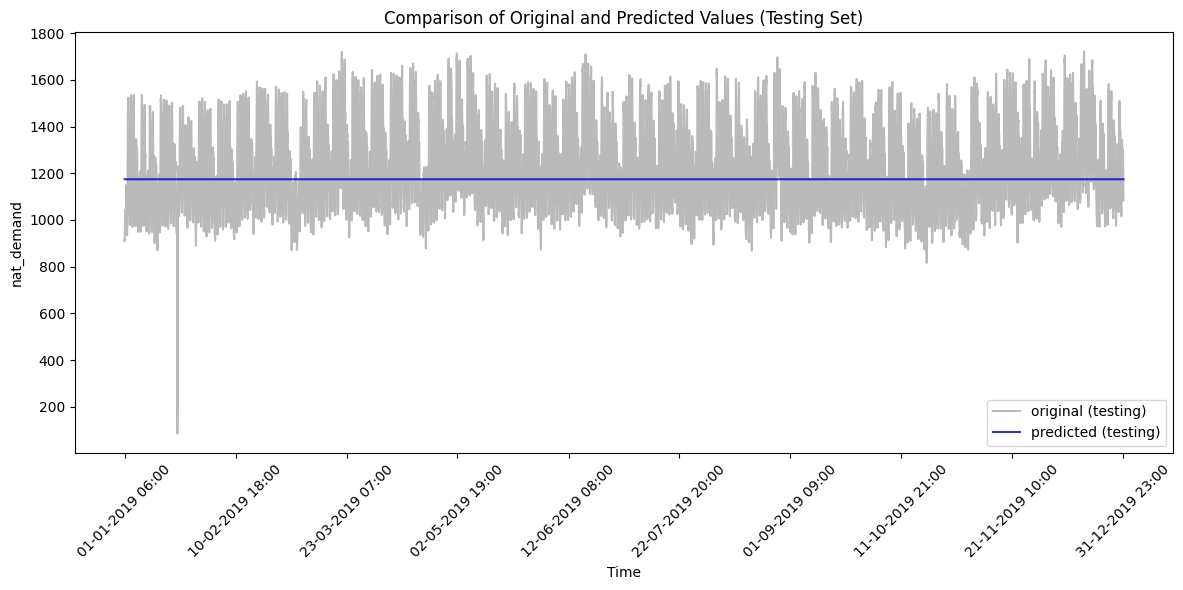

Testing Metrics (LSTM):
RMSE: 201.4093
MAE: 165.5217
MSE: 40565.7193


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Add a lag(1) feature to 'nat_demand'
df1['Lag_1'] = df1['nat_demand'].shift(1)

# Add a moving average (MA) feature with a window size of 3 to 'nat_demand'
df1['MA_3'] = df1['nat_demand'].rolling(window=3).mean()

# Drop rows with null values (NaN) in the new columns
df1.dropna(subset=['Lag_1', 'MA_3'], inplace=True)

# Create a copy of the modified DataFrame
df1_copy = df1.copy()

# Define the threshold index for splitting (e.g., 80% for training, 20% for testing)
threshold_index = int(0.8 * len(df1_copy))

# Split the dataset into training and testing using iloc
X_train = df1_copy.iloc[:threshold_index].drop(['datetime', 'nat_demand'], axis=1)
y_train = df1_copy.iloc[:threshold_index]['nat_demand']
X_test = df1_copy.iloc[threshold_index:].drop(['datetime', 'nat_demand'], axis=1)
y_test = df1_copy.iloc[threshold_index:]['nat_demand']

# Convert to NumPy arrays for LSTM input
X_train = X_train.values
X_test = X_test.values

# Reshape the input data for LSTM (batch_size, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Create an LSTM model
model = Sequential()
model.add(LSTM(300, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(LSTM(200, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape y_test_pred for plotting
y_test_pred = y_test_pred.reshape(-1)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the original data for the testing set
ax.plot(df1_copy['datetime'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df1_copy['datetime'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df1_copy) - 1, num_ticks, dtype=int)
x_ticks = df1_copy['datetime'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)

plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Testing Metrics (LSTM):")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")


In [ ]:
# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics (LSTM):")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print()
print("Testing Metrics (LSTM):")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")

Training Metrics (LSTM):
RMSE: 191.7800
MAE: 164.2892
MSE: 36779.5840

Testing Metrics (LSTM):
RMSE: 201.4093
MAE: 165.5217
MSE: 40565.7193


LSTM considering sequences(performs better)

Epoch 1/10
1095/1095 [==============================] - 32s 24ms/step - loss: 162401.0156 - val_loss: 42606.5938
Epoch 2/10
1095/1095 [==============================] - 25s 23ms/step - loss: 37017.5039 - val_loss: 43016.1875
Epoch 3/10
1095/1095 [==============================] - 24s 22ms/step - loss: 36961.9258 - val_loss: 39725.9180
Epoch 4/10
1095/1095 [==============================] - 25s 23ms/step - loss: 11520.0312 - val_loss: 8261.8398
Epoch 5/10
1095/1095 [==============================] - 26s 24ms/step - loss: 4590.3018 - val_loss: 7305.8867
Epoch 6/10
1095/1095 [==============================] - 25s 22ms/step - loss: 3872.3062 - val_loss: 6490.1846
Epoch 7/10
1095/1095 [==============================] - 23s 21ms/step - loss: 3797.9946 - val_loss: 10336.0361
Epoch 8/10
1095/1095 [==============================] - 25s 23ms/step - loss: 3464.9814 - val_loss: 9155.3193
Epoch 9/10
1095/1095 [==============================] - 26s 23ms/step - loss: 3332.0713 - val_loss: 9671.1592
E

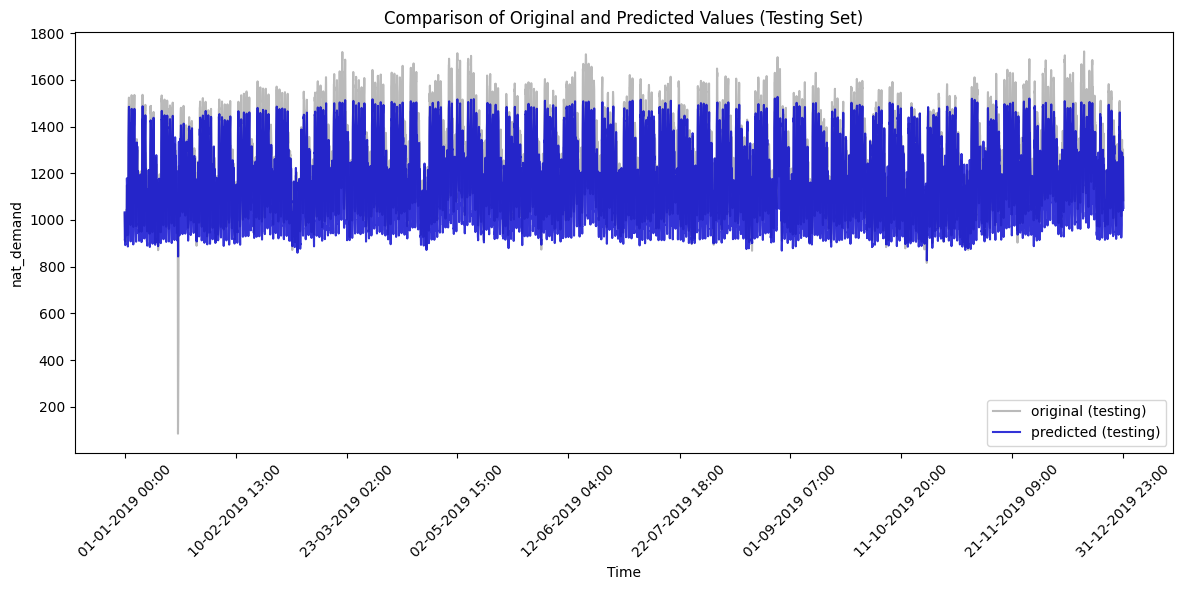

Training Metrics (LSTM):
RMSE: 73.6107
MAE: 59.3364
MSE: 5418.5417

Testing Metrics (LSTM):
RMSE: 92.9524
MAE: 77.2644
MSE: 8640.1442


In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Add a lag(1) feature to 'nat_demand'
df1['Lag_1'] = df1['nat_demand'].shift(1)

# Add a moving average (MA) feature with a window size of 3 to 'nat_demand'
df1['MA_3'] = df1['nat_demand'].rolling(window=3).mean()

# Drop rows with null values (NaN) in the new columns
df1.dropna(subset=['Lag_1', 'MA_3'], inplace=True)

# Create a copy of the modified DataFrame
df1_copy = df1.copy()

# Define the sequence length (time_stamp)
time_stamp = 7

# Convert the DataFrame into sequences
sequences = []
y_values = []

for i in range(time_stamp, len(df1_copy)):
    # Extract a sequence of data for each time step
    sequence = df1_copy.iloc[i - time_stamp:i].drop(['datetime', 'nat_demand'], axis=1)
    sequences.append(sequence.values)
    y_values.append(df1_copy.iloc[i]['nat_demand'])

X = np.array(sequences)
y = np.array(y_values)

# Split the dataset into training and testing sets based on indices
threshold_index = int(0.8 * len(X))
X_train, X_test = X[:threshold_index], X[threshold_index - time_stamp:]
y_train, y_test = y[:threshold_index], y[threshold_index - time_stamp:]

# Create an LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(100, return_sequences=True))  # Add return_sequences=True to ensure 3D output
model.add(LSTM(50))
# Additional Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

# Output layer
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the LSTM model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions for plotting
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Reshape y_test_pred for plotting
y_test_pred = y_test_pred.reshape(-1)

# Create a plot for comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the original data for the testing set
ax.plot(df1_copy['datetime'].iloc[threshold_index:], y_test, color='darkgray', alpha=0.8, label='original (testing)')

# Plot the predicted data for the testing set with the same x-values
ax.plot(df1_copy['datetime'].iloc[threshold_index:], y_test_pred, color='mediumblue', label='predicted (testing)', alpha=0.8)

ax.legend()

# Adjust x-axis ticks for better readability
num_ticks = 10
x_tick_indices = np.linspace(threshold_index, len(df1_copy) - 1, num_ticks, dtype=int)
x_ticks = df1_copy['datetime'].iloc[x_tick_indices]

plt.xticks(x_ticks, rotation=45)

plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.title('Comparison of Original and Predicted Values (Testing Set)')
plt.tight_layout()
plt.show()

# Calculate RMSE, MAE, and MSE for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE, MAE, and MSE for testing set
y_test_pred = y_test_pred[-len(y_test):]  # Ensure the lengths match
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Training Metrics (LSTM):")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MSE: {train_mse:.4f}")
print()
print("Testing Metrics (LSTM):")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MSE: {test_mse:.4f}")


We can conclude that LSTM when considering sequential data did deliver a better perfomance

### Sentiment Analysis on the Sentiment Analysis dataset using LSTM and Word2Vec

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Word2Vec

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec

# Load the training dataset
df2 = pd.read_csv('/content/drive/MyDrive/SentimentAnalysisTrain.csv', encoding='ISO-8859-1')

# Remove rows with missing values and reset the index
df2 = df2.dropna().reset_index(drop=True)

# Converting text to lowercase and removing non-alphanumeric characters
df2['text'] = df2['text'].apply(lambda x: x.lower())
df2['text'] = df2['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# Tokenization
input_data = []
for i in range(df2.shape[0]):
    input_data.append(df2['text'][i].split())
df2['text_1'] = input_data

# Functions for removing punctuation and stopwords and lemmatizing
def remove_punc_stopwords(txt: list):
    words = [word for word in txt if (word.startswith('!')) or \
        (word.startswith('?')) or (word not in string.punctuation)]

    words = [word for word in words if word.lower() not in stop_words]

    return words

def lemmatize(txt: list):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in txt]

    return lemmas

# Apply text preprocessing functions
df2['text_1'] = df2['text_1'].apply(lambda x: remove_punc_stopwords(x))
df2['text_1'] = df2['text_1'].apply(lambda x: lemmatize(x))
input_list = df2['text_1']

df2['text_1'] = df2['text_1'].apply(lambda x: ' '.join(x))

# Train a Word2Vec model
model = Word2Vec(
        df2['text_1'].to_list(),
        vector_size=600,
        window=20,
        min_count=5,
        workers=10)

# Create a function to generate document vectors using Word2Vec
def generate_document_vector(tokens, model):
    # Filter tokens that are in the Word2Vec model's vocabulary
    valid_tokens = [token for token in tokens if token in model.wv.key_to_index]

    # Calculate the mean of word vectors for the valid tokens
    if valid_tokens:
        doc_vector = model.wv[valid_tokens].mean(axis=0)
    else:
        # Handle the case where no valid tokens are found
        doc_vector = None

    return doc_vector

# Create document vectors for each row in df2
df2['doc_vector'] = df2['text_1'].apply(lambda tokens: generate_document_vector(tokens, model))

# Drop rows with missing document vectors (e.g., if all tokens were out-of-vocabulary)
df2.dropna(subset=['doc_vector'], inplace=True)

# Split the data into training and testing sets
X_train = np.array(df2['doc_vector'].tolist())

# Apply Standard Scaling to the feature vectors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

y_train = df2['sentiment']  # Assuming you have a 'sentiment' column in your DataFrame

# Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Load and preprocess the test dataset
df_test = pd.read_csv('/content/drive/MyDrive/SentimentAnalysisTest.csv', encoding='ISO-8859-1')

# Remove rows with missing values and reset the index
df_test = df_test.dropna().reset_index(drop=True)

# Converting text to lowercase and removing non-alphanumeric characters
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# Tokenization
input_data = []
for i in range(df_test.shape[0]):
    input_data.append(df_test['text'][i].split())

df_test['text_1'] = input_data
df_test['text_1'] = df_test['text_1'].apply(lambda x: remove_punc_stopwords(x))
df_test['text_1'] = df_test['text_1'].apply(lambda x: lemmatize(x))
input_list = df_test['text_1']
df_test['text_1'] = df_test['text_1'].apply(lambda x: ' '.join(x))

df_test['doc_vector'] = df_test['text_1'].apply(lambda tokens: generate_document_vector(tokens, model))

# Drop rows with missing document vectors (e.g., if all tokens were out-of-vocabulary)
df_test.dropna(subset=['doc_vector'], inplace=True)

# Split the data into test sets
X_test = np.array(df_test['doc_vector'].tolist())

# Scale the test set using the same scaler used for the training set
X_test = scaler.transform(X_test)

y_test = df_test['sentiment']  # Assuming you have a 'sentiment' column in your DataFrame

# Make predictions on the test set
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Evaluate the model's performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_report = classification_report(y_train, y_train_pred, target_names=["Negative", "Neutral", "Positive"])
test_report = classification_report(y_test, y_test_pred, target_names=["Negative", "Neutral", "Positive"])

# Print accuracy and classification reports
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Classification Report for Training Data:\n", train_report)
print("Classification Report for Test Data:\n", test_report)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.4428482881831772
Test Accuracy: 0.4498014747589336
Classification Report for Training Data:
               precision    recall  f1-score   support

    Negative       0.45      0.24      0.32      7778
     Neutral       0.43      0.69      0.53     11068
    Positive       0.46      0.30      0.36      8581

    accuracy                           0.44     27427
   macro avg       0.45      0.41      0.41     27427
weighted avg       0.45      0.44      0.42     27427

Classification Report for Test Data:
               precision    recall  f1-score   support

    Negative       0.46      0.25      0.32      1000
     Neutral       0.44      0.71      0.54      1423
    Positive       0.48      0.30      0.37      1103

    accuracy                           0.45      3526
   macro avg       0.46      0.42      0.41      3526
weighted avg       0.46      0.45      0.43      3526



LSTM Model 1

Epoch 1/10
687/687 [==============================] - 127s 179ms/step - loss: 0.8282 - accuracy: 0.6207 - val_loss: 0.6981 - val_accuracy: 0.6974
Epoch 2/10
687/687 [==============================] - 126s 183ms/step - loss: 0.6556 - accuracy: 0.7314 - val_loss: 0.6798 - val_accuracy: 0.7105
Epoch 3/10
687/687 [==============================] - 127s 185ms/step - loss: 0.6140 - accuracy: 0.7485 - val_loss: 0.6690 - val_accuracy: 0.7220
Epoch 4/10
687/687 [==============================] - 127s 185ms/step - loss: 0.5838 - accuracy: 0.7636 - val_loss: 0.6781 - val_accuracy: 0.7220
Epoch 5/10
687/687 [==============================] - 123s 180ms/step - loss: 0.5600 - accuracy: 0.7728 - val_loss: 0.6726 - val_accuracy: 0.7273
Epoch 6/10
687/687 [==============================] - 125s 182ms/step - loss: 0.5395 - accuracy: 0.7820 - val_loss: 0.6813 - val_accuracy: 0.7254
Epoch 7/10
687/687 [==============================] - 129s 188ms/step - loss: 0.5135 - accuracy: 0.7940 - val_loss: 0.7045 -

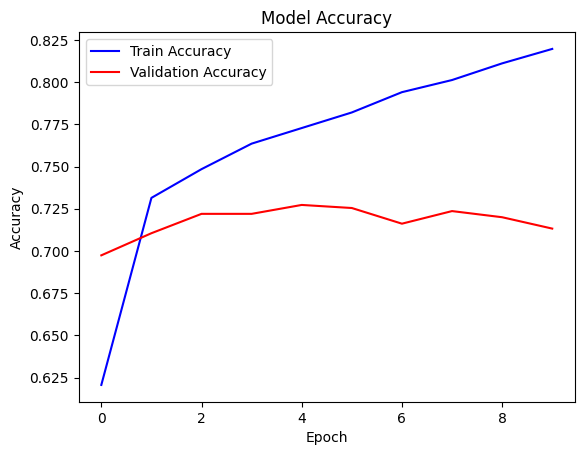

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the training dataset
df2 = pd.read_csv('/content/drive/MyDrive/SentimentAnalysisTrain.csv', encoding='ISO-8859-1')

# Remove rows with missing values and reset the index
df2 = df2.dropna().reset_index(drop=True)

# Converting text to lowercase and removing non-alphanumeric characters
df2['text'] = df2['text'].apply(lambda x: x.lower())
df2['text'] = df2['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# Tokenization
input_data = []
for i in range(df2.shape[0]):
    input_data.append(df2['text'][i].split())
df2['text_1'] = input_data

# Functions for removing punctuation and stopwords and lemmatizing
def remove_punc_stopwords(txt: list):
    words = [word for word in txt if (word.startswith('!')) or \
        (word.startswith('?')) or (word not in string.punctuation)]

    words = [word for word in words if word.lower not in stop_words]

    return words

def lemmatize(txt: list):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in txt]

    return lemmas

# Apply text preprocessing functions
df2['text_1'] = df2['text_1'].apply(lambda x: remove_punc_stopwords(x))
df2['text_1'] = df2['text_1'].apply(lambda x: lemmatize(x))
input_list = df2['text_1']

df2['text_1'] = df2['text_1'].apply(lambda x: ' '.join(x))

# Tokenize the text
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(df2['text_1'].values)

X = tokenizer.texts_to_sequences(df2['text_1'].values)
# Set the sequence length to match the length used during training
max_len = len(max(X, key=len))  # Find the maximum sequence length in your training data
X = pad_sequences(X, maxlen=max_len)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential()
model.add(Embedding(2000, 128, input_length=max_len))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model with validation data
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

# Load and preprocess the test dataset
df_test = pd.read_csv('/content/drive/MyDrive/SentimentAnalysisTest.csv', encoding='ISO-8859-1')

# Remove rows with missing values and reset the index
df_test = df_test.dropna().reset_index(drop=True)

# Converting text to lowercase and removing non-alphanumeric characters
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# Tokenization
input_data = []
for i in range(df_test.shape[0]):
    input_data.append(df_test['text'][i].split())

df_test['text_1'] = input_data
df_test['text_1'] = df_test['text_1'].apply(lambda x: remove_punc_stopwords(x))
df_test['text_1'] = df_test['text_1'].apply(lambda x: lemmatize(x))
input_list = df_test['text_1']
df_test['text_1'] = df_test['text_1'].apply(lambda x: ' '.join(x))

X_test = tokenizer.texts_to_sequences(df_test['text_1'].values)
# Set the sequence length to match the length used during training
X_test = pad_sequences(X_test, maxlen=max_len)

y_test = to_categorical(pd.Categorical(df_test['sentiment']).codes, num_classes=3)

# Evaluate the LSTM model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X, y, verbose=0)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Create a plot of training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# Code for model evaluation and classification report
possible_sentiments = np.array(['negative', 'positive', 'neutral'])
X_test_eval = df_test['text'].to_list()
y_test_eval = pd.get_dummies(df_test['sentiment']).values

X_test_eval = tokenizer.texts_to_sequences(X_test_eval)
X_test_eval = pad_sequences(X_test_eval, maxlen=max_len, dtype='int32', value=0)

y_pred_eval = model.predict(X_test_eval)

111/111 [==============================] - 5s 49ms/step


In [ ]:
# Actual sentiments
idx1_eval = np.argmax(y_test_eval, axis=1)
actual_sentiments_eval = possible_sentiments[idx1_eval]

In [ ]:
print(actual_sentiments_eval)

['positive' 'neutral' 'negative' ... 'negative' 'neutral' 'neutral']


In [ ]:
# Predicted sentiments
idx2_eval = np.argmax(y_pred_eval, axis=1)
predicted_sentiments_eval = possible_sentiments[idx2_eval]

In [ ]:
print(predicted_sentiments_eval)

['positive' 'neutral' 'negative' ... 'positive' 'neutral' 'neutral']


In [ ]:
# Classification report
y_test_1_eval = np.argmax(y_test_eval, axis=1)
y_pred_1_eval = np.argmax(y_pred_eval, axis=1)

# Print Classification Report for the evaluation
print("Evaluation Classification Report:")
print(classification_report(y_test_1_eval, y_pred_1_eval))

Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.55      0.63      1001
           1       0.61      0.74      0.67      1430
           2       0.74      0.71      0.72      1103

    accuracy                           0.67      3534
   macro avg       0.69      0.66      0.67      3534
weighted avg       0.68      0.67      0.67      3534



LSTM Model 2

Epoch 1/20
687/687 [==============================] - 136s 193ms/step - loss: 0.8411 - accuracy: 0.6088 - val_loss: 0.7204 - val_accuracy: 0.6981
Epoch 2/20
687/687 [==============================] - 132s 193ms/step - loss: 0.6631 - accuracy: 0.7282 - val_loss: 0.6861 - val_accuracy: 0.7223
Epoch 3/20
687/687 [==============================] - 128s 187ms/step - loss: 0.6225 - accuracy: 0.7494 - val_loss: 0.6750 - val_accuracy: 0.7254
Epoch 4/20
687/687 [==============================] - 128s 187ms/step - loss: 0.5885 - accuracy: 0.7650 - val_loss: 0.6741 - val_accuracy: 0.7209
Epoch 5/20
687/687 [==============================] - 130s 189ms/step - loss: 0.5685 - accuracy: 0.7688 - val_loss: 0.6692 - val_accuracy: 0.7271
Epoch 6/20
687/687 [==============================] - 131s 191ms/step - loss: 0.5478 - accuracy: 0.7793 - val_loss: 0.6881 - val_accuracy: 0.7247
Epoch 7/20
687/687 [==============================] - 129s 187ms/step - loss: 0.5231 - accuracy: 0.7909 - val_loss: 0.7008 -

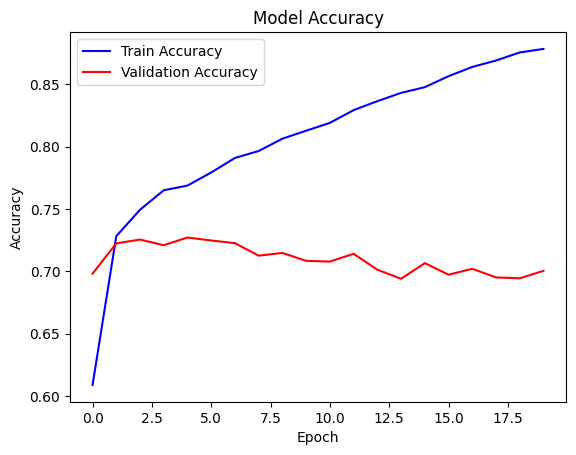

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the training dataset
df2 = pd.read_csv('/content/drive/MyDrive/SentimentAnalysisTrain.csv', encoding='ISO-8859-1')

# Remove rows with missing values and reset the index
df2 = df2.dropna().reset_index(drop=True)

# Converting text to lowercase and removing non-alphanumeric characters
df2['text'] = df2['text'].apply(lambda x: x.lower())
df2['text'] = df2['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# Tokenization
input_data = []
for i in range(df2.shape[0]):
    input_data.append(df2['text'][i].split())
df2['text_1'] = input_data

# Functions for removing punctuation and stopwords and lemmatizing
def remove_punc_stopwords(txt: list):
    words = [word for word in txt if (word.startswith('!')) or \
        (word.startswith('?')) or (word not in string.punctuation)]

    words = [word for word in words if word.lower not in stop_words]

    return words

def lemmatize(txt: list):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in txt]

    return lemmas

# Apply text preprocessing functions
df2['text_1'] = df2['text_1'].apply(lambda x: remove_punc_stopwords(x))
df2['text_1'] = df2['text_1'].apply(lambda x: lemmatize(x))
input_list = df2['text_1']

df2['text_1'] = df2['text_1'].apply(lambda x: ' '.join(x))

# Tokenize the text
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(df2['text_1'].values)

X = tokenizer.texts_to_sequences(df2['text_1'].values)
# Set the sequence length to match the length used during training
max_len = len(max(X, key=len))  # Find the maximum sequence length in your training data
X = pad_sequences(X, maxlen=max_len)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential()
model.add(Embedding(2000, 128, input_length=max_len))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model with validation data
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

# Load and preprocess the test dataset
df_test = pd.read_csv('/content/drive/MyDrive/SentimentAnalysisTest.csv', encoding='ISO-8859-1')

# Remove rows with missing values and reset the index
df_test = df_test.dropna().reset_index(drop=True)

# Converting text to lowercase and removing non-alphanumeric characters
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

# Tokenization
input_data = []
for i in range(df_test.shape[0]):
    input_data.append(df_test['text'][i].split())

df_test['text_1'] = input_data
df_test['text_1'] = df_test['text_1'].apply(lambda x: remove_punc_stopwords(x))
df_test['text_1'] = df_test['text_1'].apply(lambda x: lemmatize(x))
input_list = df_test['text_1']
df_test['text_1'] = df_test['text_1'].apply(lambda x: ' '.join(x))

X_test = tokenizer.texts_to_sequences(df_test['text_1'].values)
# Set the sequence length to match the length used during training
X_test = pad_sequences(X_test, maxlen=max_len)

y_test = to_categorical(pd.Categorical(df_test['sentiment']).codes, num_classes=3)

# Evaluate the LSTM model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Evaluate the model on the training set
train_loss, train_accuracy = model.evaluate(X, y, verbose=0)

print("Training Loss:", train_loss)
print("Training Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Create a plot of training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
# Code for model evaluation and classification report
possible_sentiments = np.array(['negative', 'positive', 'neutral'])
X_test_eval = df_test['text'].to_list()
y_test_eval = pd.get_dummies(df_test['sentiment']).values

X_test_eval = tokenizer.texts_to_sequences(X_test_eval)
X_test_eval = pad_sequences(X_test_eval, maxlen=max_len, dtype='int32', value=0)

y_pred_eval = model.predict(X_test_eval)

111/111 [==============================] - 6s 46ms/step


In [ ]:
# Actual sentiments
idx1_eval = np.argmax(y_test_eval, axis=1)
actual_sentiments_eval = possible_sentiments[idx1_eval]

In [ ]:
print(actual_sentiments_eval)

['positive' 'neutral' 'negative' ... 'negative' 'neutral' 'neutral']


In [ ]:
# Predicted sentiments
idx2_eval = np.argmax(y_pred_eval, axis=1)
predicted_sentiments_eval = possible_sentiments[idx2_eval]

In [ ]:
print(predicted_sentiments_eval)

['positive' 'neutral' 'negative' ... 'positive' 'neutral' 'neutral']


In [ ]:
# Classification report
y_test_1_eval = np.argmax(y_test_eval, axis=1)
y_pred_1_eval = np.argmax(y_pred_eval, axis=1)

# Print Classification Report for the evaluation
print("Evaluation Classification Report:")
print(classification_report(y_test_1_eval, y_pred_1_eval))

Evaluation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.57      0.62      1001
           1       0.60      0.73      0.66      1430
           2       0.75      0.66      0.70      1103

    accuracy                           0.66      3534
   macro avg       0.68      0.65      0.66      3534
weighted avg       0.67      0.66      0.66      3534



Conclusion :  Model 1 is the better-performing model with a slightly higher accuracy and better F1-scores.